In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score


In [0]:
# RFM 기반 데이터 분석

# 고객 세그먼테이션(customer segmentation)
# 다양한 기준으로 고객을 분류하는 기법
# CRM이나 마케팅의 중요한 기반 요소

# 고객을 분류하는 방법은 다양함
# => 거주지역/결혼여부/성별/소득/직업
# => 선호상품군/월별사용액/최근구매상품/구매주기
# ==> 기업입장에서는 얼마나 많은 매출을 발생하느냐가 
#     고객 기준을 정하는 중요한 요소
# ==> 주요 목표는 타겟 마케팅!!

# 따라서, 고객의 어떤 요소를 기반으로 
# 군집화 할 것인가를 결정하는 것이 중요
# => RFM 기법 이용
# => recency, frequency, monetary


# recency 구매 최근성
# 고객의 마지막 구매시점이 언제인지를 의미

# frequency 구매 빈도
# 고객이 정해진 기간동안 얼마나 자주 구매했나

# monetary 구매 금액
# 일정기간 동안에 고객의 총 구매금액을 나타냄

# RFM 지수 = a * R + b * F + c * M
# a, b, c는 가중치


# recency 가 중요한 산업 : 유통업(백화점, 보험)
# frequency 가 중요한 산업 : 통신업, 유통업, 서비스업
# monetary 가 중요한 산업 : 금융업(카드사)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


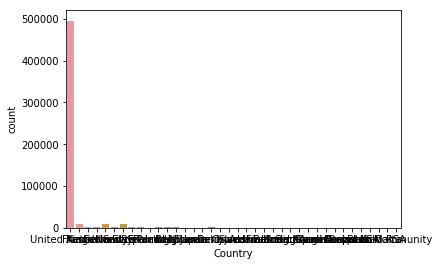

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


InvoiceNo  StockCode
536365     21730        1
           22752        1
           71053        1
           84029E       1
           84029G       1
           84406B       1
           85123A       1
536366     22632        1
           22633        1
536367     21754        1
Name: InvoiceNo, dtype: int64

In [83]:
# 데이터 적재
retail = pd.read_csv('Online Retail.csv')
# => 영국 온라인 소매업 스토어에서 발생한 거래 데이터
#    2010.01 ~ 2011.09 까지의 데이터 저장
# 구매국가는 다양함

retail.info()
# 송장번호(c로 시작한 송장번호는 구매 취소)
# 제품코드(5자리), 설명, 수량, 송장날짜, 가격, 고객ID, 국가(고객거주)
# 전체 데이터 : 541909 
# 고객 ID : 406829 

retail.head()
retail.describe()   # 수량과 가격이 마이너스로 표시



# 마케팅을 적용할 대상 국가 선정
retail.Country.value_counts()

sns.countplot(retail.Country)
plt.show()
# => 고객 분포는 영국, 독일, 프랑스, 아일랜드 순
# 따라서, 영국 고객들을 대상으로 RFM 분석



# 고객 ID 데이터 수가 406829 이므로 적절한 기준으로 결측치 처리함
# 구매수량, 구매가격이 0 이상인 데이터를 대상으로 결측치 처리함
retail.shape   # (541909, 8)

retail.isnull().sum()

retaildf = retail[retail.Quantity > 0]
retaildf = retaildf[retail.UnitPrice > 0]
retaildf = retaildf[retail.CustomerID.notnull()]

retaildf.isnull().sum()

retaildf.shape   # (397884, 8)



# 고객을 영국을 한정함
retaildf.Country.value_counts()[:5]

retailuk = retaildf[retaildf.Country == 'United Kingdom']

retailuk.Country.value_counts()[:5]   # 354321



# 탐색적 분석(EDA)
retailuk.describe()



# BFM 분석
# 분석에 필요한 컬럼들로만 필터링
retailuk.columns

uk_data = retailuk[[
    'CustomerID',
    'InvoiceDate',
    'InvoiceNo',
    'StockCode',
    'Quantity',
    'UnitPrice' ]]

# 고객번호를 정수로 변환
uk_data['CustomerID'] = uk_data.loc[:,'CustomerID'].astype(int)

# 수량과 단가를 이용해서 주문금액 산출
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']

# 고객별 주문건수 확인
uk_data['CustomerID'].value_counts().head(10)

# 고객별 주문금액 확인
uk_data.groupby('CustomerID')['TotalPrice'].sum().sort_values(
    ascending=False)[:10]

# 주문건수가 많다고 해서 총주문금액이 높은 것은 아님
# => 주문건당 금액이 높기 때문임




# 상품별 주문빈도 파악
uk_data['StockCode'].value_counts()
uk_data['StockCode'].value_counts().head(10)

uk_data.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count()[:10]

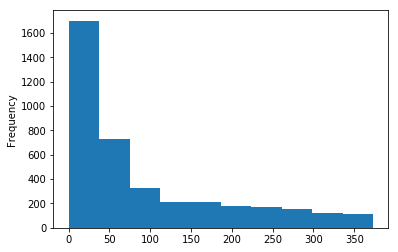

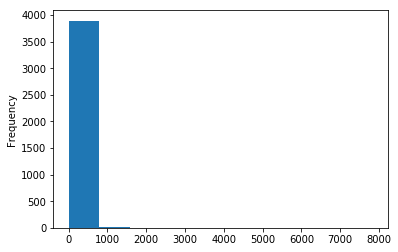

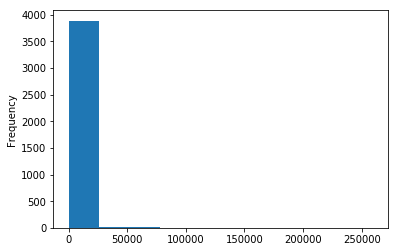

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,91.742092,90.388010,1864.385601
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,0.000000,1.000000,3.750000
25%,14208.750000,17.000000,17.000000,300.280000
50%,15569.500000,50.000000,41.000000,652.280000
75%,16913.250000,142.000000,99.250000,1576.585000
max,18287.000000,373.000000,7847.000000,259657.300000


In [82]:
# RFM 기반 고객 세그먼테이션 수행
# => 고객 기준 주문기간, 주문횟수, 주문금액 산출

# Recency : 고객별 주문기간, 
#           분석일 기준 최근 주문일(days)
# Frequency : 고객별 주문건수
# Monetary : 고객별 주문금액

uk_data['Recency'] : uk_data.groupby('CustomerID')['InvoiceDate'].max()
uk_data['Frequency'] : uk_data.groupby('CustomerID')['InvoiceNo'].count()
uk_data['Monetary'] : uk_data.groupby('CustomerID')['TotalPrice'].sum()



# 독립적인 데이터프레임을 생성한 후 고객에 대한 RFM 분석 저장
uk_RFM_data  = uk_data.groupby('CustomerID').agg(
    { 'InvoiceDate' : 'max',
      'InvoiceNo' : 'count', 
      'TotalPrice' : 'sum' })



# 컬럼명을 R / F / M 으로 변경
uk_RFM_data.rename(columns={
    'InvoiceDate' : 'Recency', 
    'InvoiceNo' : 'Frequency', 
    'TotalPrice' : 'Monetary'}, inplace=True)



# 데이터프레임의 인덱스가 고객 ID 이므로
# 인덱스를 재조정함
uk_RFM_data = uk_RFM_data.reset_index()



# Recency 재가공
# Recency는 분석일 기준 고객당 최근 주문
# => Recency = 분석일 - 최근 주문일
uk_data['InvoiceDate'].min()   # 2010-12-01
uk_data['InvoiceDate'].max()   # 2011-12-09

# 따라서, 분석일은 2011-12-10 로 설정
# 날짜 연산을 위해 pandas에서 지원하는 날짜형으로 변환
# '2011-12-10' - '2011-12-01' => 계산불가!! 
pd.to_datetime('2011-12-10') - pd.to_datetime('2011-12-01')
# => Timedelta('9 days 00:00:00')

uk_RFM_data['Recency'] = \
pd.to_datetime('2011-12-10') - pd.to_datetime(uk_RFM_data['Recency'])

# 계산된 결과에서 일수만 추출
uk_RFM_data['Recency'] = uk_RFM_data['Recency'].dt.days



# RFM 분석 결과를 시각화
uk_RFM_data['Recency'].plot(kind='hist')
plt.show()

uk_RFM_data['Frequency'].plot(kind='hist')
plt.show()

uk_RFM_data['Monetary'].plot(kind='hist')
plt.show()
# 데이터 분포는 왜곡되어 있음 - 한 쪽으로 쏠림



# RFM 분석 결과에 기술통계
uk_RFM_data.describe()

#          	 Recency	      Frequency	        Monetary
# count	     3920.000000	  3920.000000	    3920.000000
# mean	   	 91.742092 	      90.388010	        1864.385601
# std	   	 99.533485	      217.808385	    7482.817477
# min	   	 0.000000	      1.000000	        3.750000
# 25%	   	 17.000000	      17.000000	        300.280000
# 50%	   	 50.000000	      41.000000	        652.280000
# 75%	     142.000000	      99.250000	        1576.585000
# max	   	 373.000000	      7847.000000	    259657.300000

# 평균이 중위수보다 큼 => 이상치에 의해 평균이 끌어올려졌음을 의미
# 정규분포 아님 => 왜곡이 심한편임을 알 수 있음
# => 왜곡 정도가 높은 데이터에 대해 
#    kmeans 군집화를 적용시키면 변별력이 떨어지는 결과 도출
# ==> 정규화를 통해 평균과 표준편차 재조정 필요

In [92]:
# 정규화 수행후 kmeans 군집화 적용
from sklearn.preprocessing import StandardScaler

X = uk_RFM_data.iloc[:, 1:4]
X_scaled = StandardScaler().fit_transform(X)

kms = KMeans(n_clusters=3, random_state=0)
labeled = kms.fit_predict(X_scaled)

print('실루엣 점수', silhouette_score(X_scaled, labeled))
# => 실루엣 점수 0.5923691942714455


kms = KMeans(n_clusters=5, random_state=0)
labeled = kms.fit_predict(X_scaled)

print('실루엣 점수', silhouette_score(X_scaled, labeled))
# => 실루엣 점수 0.6036943581226247



# 군집별 분포수 확인
pd.Series(labeled2).value_counts()
# 각 군집별 분포수는 균일하지 않음



# 실루엣 그래프 시각화
import kmeans_eval

kmeans_eval.visualize_silhouette([3, 4, 5], X_scaled)
# 그래프를 확인해보면 군집이 제대로 이루어지지 않음
# => 분포가 왜곡되어 있어 데이터들이 겹쳐져있기 때문 



# 왜곡된 데이터 분포를 재조정하기 위해 
# 데이터 값에 로그를 적용하는 로그변환 사용
uk_RFM_data['Recency_log'] = np.log1p(uk_RFM_data['Recency'])
uk_RFM_data['Frequency_log'] = np.log1p(uk_RFM_data['Frequency'])
uk_RFM_data['Monetary_log'] = np.log1p(uk_RFM_data['Monetary'])
# 각 값에 log 적용시 결과값이 무한대로 발산되는 경우(-inf)를 
# 방지하기 위해 결과값에 +1 해주는 로그함수 사용

a = np.array([0, 12345])
np.log(a)   # -inf, 9.4210064
np.log1p(a)



# 로그변환된 데이터를 이용해서 kmeans 군집화 적용하기
X2 = uk_RFM_data.iloc[:, 4:7]

X2_scaled = StandardScaler().fit_transform(X2)
kms = KMeans(n_clusters=3, random_state=0)

labeled2 = kms.fit_predict(X2_scaled)

print('실루엣 점수', silhouette_score(X2_scaled, labeled2))
# 실루엣 점수 0.3062580508120836


kmeans_eval.visualize_silhouette([3, 4, 5], X2_scaled)
# 실루엣 점수는 낮지만, 로그변환 덕택으로 인해 군집화는 잘 되었음

1    791
2    788
3    786
5    783
4    772
Name: R_quart, dtype: int64

In [105]:
# 프로그래밍 관점에서 RFM 분석
# RFM 데이터를 구간별로 나눠서 가중치 부여
# qcut(데이터, 구간수, 가중치리스트)

uk_RFM_data['R_quart'] = pd.qcut(
    uk_RFM_data['Recency'], 5, ['1', '2', '3', '4', '5'])
uk_RFM_data['R_quart'].value_counts()
# 주문일자 기준, 가장 최근에 주문한 고객에게 높은 가중치 부여

uk_RFM_data['F_quart'] = pd.qcut(
    uk_RFM_data['Frequency'], 5, ['1', '2', '3', '4', '5'])
uk_RFM_data['Frequency'].value_counts()
# 주문빈도가 높은 고객에게 높은 가중치 부여

uk_RFM_data['M_quart'] = pd.qcut(
    uk_RFM_data['Monetary'], 5, ['1', '2', '3', '4', '5'])
uk_RFM_data['Monetary'].value_counts()
# 주문금액이 높은 고객에게 높은 가중치 부여



# RFM 점수 산출
uk_RFM_data.iloc[:, 7:10].head(5)

uk_RFM_data['RFM score'] = uk_RFM_data.R_quart.astype(str) + \
                           uk_RFM_data.F_quart.astype(str) + \
                           uk_RFM_data.M_quart.astype(str) 

uk_RFM_data.iloc[:, 7:12].head(10)

uk_RFM_data.iloc[:, [0, 1, 2, 3, 10]].sort_values(
    'RFM score', ascending = False).head(10)

uk_RFM_data.iloc[:, [0, 1, 2, 3, 10]].sort_values(
    'Monetary', ascending = False).head(10)   # 주문금액 많은 순

uk_RFM_data.iloc[:, [0, 1, 2, 3, 10]].sort_values(
    'Frequency', ascending = False).head(10)   # 주문빈도 많은 순

uk_RFM_data.iloc[:, [0, 1, 2, 3, 10]].sort_values(
    'Recency', ascending = True).head(10)   # 주문일자 최근 순


,CustomerID,Recency,Frequency,Monetary,RFM score
2598,16446,0,3,168472.50,115
3272,17389,0,213,31833.68,155
179,13069,0,425,4436.12,155
2971,16954,0,54,2085.08,135
2678,16558,0,460,8338.49,155
2726,16626,0,179,4413.10,155
118,12985,0,76,1239.38,144
3539,17754,0,92,1772.26,144
870,14051,0,210,15610.39,155
2134,15804,0,262,4206.39,155
